In [4]:
import import_ipynb
import utils
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split


In [5]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")

data_climat = np.array(data_climat)
data_climat = pd.DataFrame(data_climat.squeeze())
X_list = []

for annee in range(11, 19):
        
    data_pop_slice = data_pop[annee].iloc[:, :]
    data_fertility_slice = data_fertility[annee].iloc[:, 1:]
    data_child_slice = data_child[annee].iloc[:, 1:]
    data_capita_slice = data_capita[annee].iloc[:, 1:]
    data_climat_slice = data_climat.iloc[:, 1:]
    
    concatenated_data = np.concatenate((
        data_pop_slice, 
        data_fertility_slice, 
        data_child_slice, 
        data_capita_slice,
        data_climat_slice
    ), axis=1)

    X_list.append(concatenated_data)

X = np.vstack(X_list)

In [6]:
#preparation des labels pour classification 1992-->2020
import pandas as pd

label_class = pd.read_csv("labels_class.csv")
label_class.head()

labels_list = []
for i in range(len(label_class)):
    label = label_class.iloc[i, :-1]
    labels_list.append(label)

y_class = pd.concat(labels_list, axis=0, ignore_index=True)

In [7]:
# création des label pour tous les événements 1992->2020
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")

labels_list = []
for i in range(len(df_delegations)):
    label = df_delegations.iloc[i, :-1]
    labels_list.append(label)

y = pd.concat(labels_list, axis=0, ignore_index=True)


(1144,)

In [ ]:

#récupération des pays
country_names = X[:, 0]
X = X[:, 1:]
# convertion des données en float32
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_class = np.array(y_class, dtype=np.float32)
# séparation des données en train et test
X_train, X_test, y_train, y_test, country_train, country_test, cl_train, cl_test = train_test_split(
    X, y, country_names, y_class,  test_size=0.2, random_state=42)



Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - classification_output_accuracy: 0.0000e+00 - classification_output_loss: 0.1672 - loss: 0.5043 - regression_output_loss: 0.3373 - regression_output_mse: 0.0282 - val_classification_output_accuracy: 0.0000e+00 - val_classification_output_loss: 0.0888 - val_loss: 0.7056 - val_regression_output_loss: 0.5876 - val_regression_output_mse: 0.0395
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.0000e+00 - classification_output_loss: 0.0725 - loss: 0.2907 - regression_output_loss: 0.2181 - regression_output_mse: 0.0263 - val_classification_output_accuracy: 0.0000e+00 - val_classification_output_loss: 0.0419 - val_loss: 0.6585 - val_regression_output_loss: 0.5876 - val_regression_output_mse: 0.0395
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - classification_output_accuracy: 0.0000e+00 - classification_output_loss: 0.0401 - loss: 0.5238 - regression_output_loss: 0.4837 - regression_output_mse: 0.0372

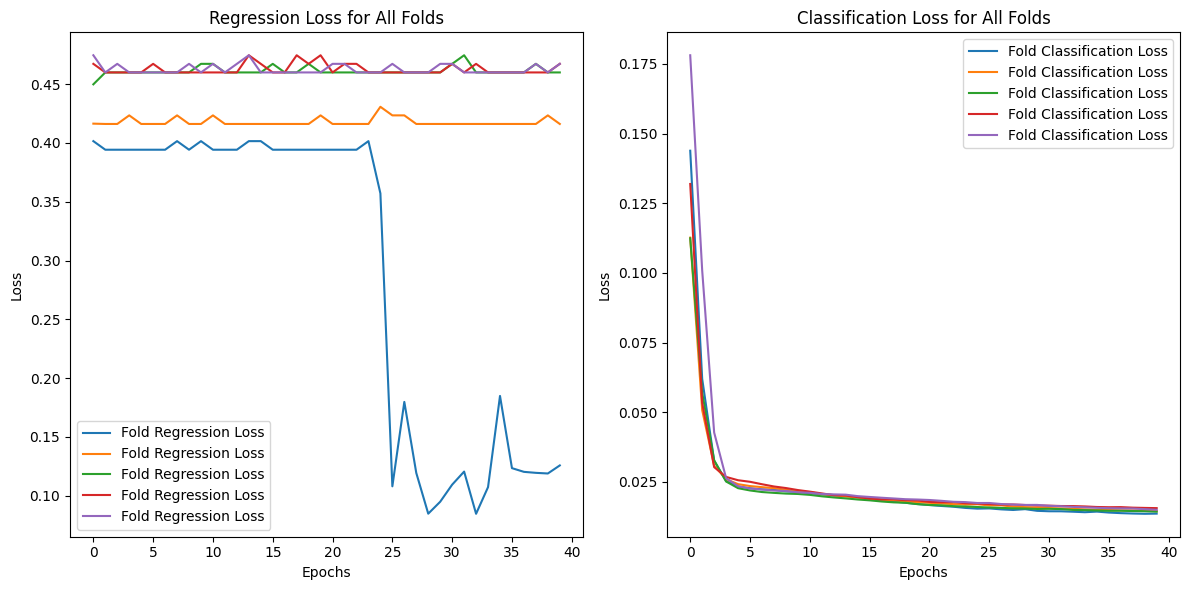

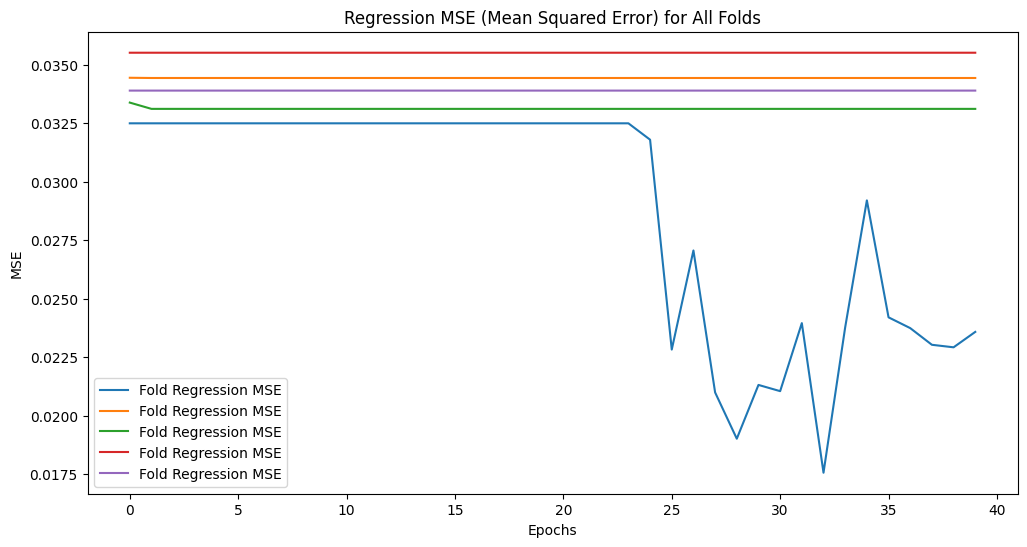

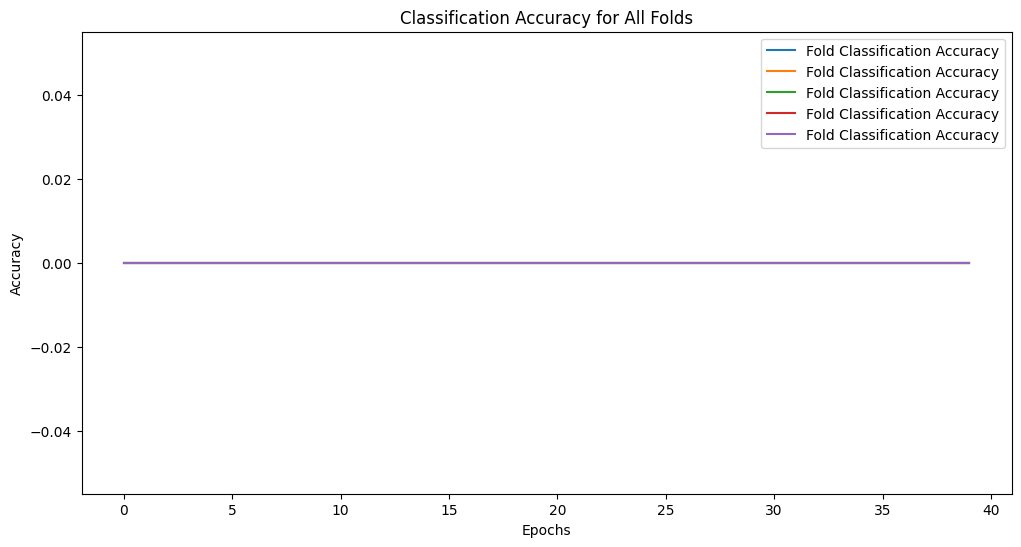

Average Validation Loss across 5 folds: 0.37407427430152895
Average Validation Accuracy across 5 folds: 0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import MeanSquaredError as MSE, Accuracy

n_folds = 5

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

regression_loss_per_fold = []
classification_loss_per_fold = []
regression_mse_per_fold = []
classification_accuracy_per_fold = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    cl_train_fold, cl_val_fold = cl_train[train_index], cl_train[val_index]

    inputs = Input(shape=(X_train.shape[1],))
    x1 = Dense(10, activation='relu')(inputs)
    x2_reg = Dense(8, activation='relu')(x1)

    output_reg = Dense(1, activation='relu', name='regression_output')(x2_reg)
    output_clf = Dense(1, activation='sigmoid', name='classification_output')(x1)

    model = Model(inputs=inputs, outputs=[output_reg, output_clf])
    model.compile(
        optimizer=Adam(),
        loss={'regression_output': MeanSquaredError(), 'classification_output': BinaryCrossentropy()},
        metrics={'regression_output': 'mse', 'classification_output': Accuracy()}
    )

    history = model.fit(
        X_train_fold, 
        {'regression_output': y_train_fold, 'classification_output': cl_train_fold}, 
        epochs=40, 
        batch_size=16, 
        validation_data=(X_val_fold, {'regression_output': y_val_fold, 'classification_output': cl_val_fold}),
        verbose=1
    )

    regression_loss_per_fold.append(history.history['regression_output_loss'])
    classification_loss_per_fold.append(history.history['classification_output_loss'])
    regression_mse_per_fold.append(history.history['regression_output_mse'])
    classification_accuracy_per_fold.append(history.history['classification_output_accuracy'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for loss in regression_loss_per_fold:
    plt.plot(loss, label='Fold Regression Loss')
plt.title('Regression Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for loss in classification_loss_per_fold:
    plt.plot(loss, label='Fold Classification Loss')
plt.title('Classification Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for mse in regression_mse_per_fold:
    plt.plot(mse, label='Fold Regression MSE')
plt.title('Regression MSE (Mean Squared Error) for All Folds')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for acc in classification_accuracy_per_fold:
    plt.plot(acc, label='Fold Classification Accuracy')
plt.title('Classification Accuracy for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

avg_val_loss = np.mean([np.min(loss) for loss in regression_loss_per_fold])
avg_val_accuracy = np.mean([np.max(acc) for acc in classification_accuracy_per_fold])

print(f'Average Validation Loss across {n_folds} folds: {avg_val_loss}')
print(f'Average Validation Accuracy across {n_folds} folds: {avg_val_accuracy}')


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
# version simple du NN en format NON séquentiel
"""

inputs = Input(shape=(X_train.shape[1],))

x = Dense(50, activation='relu')(inputs)
#x = Dropout(0.3)(x)

#x = Dense(16, activation='relu')(x)
#x = Dropout(0.3)(x)

x = Dense(12, activation='relu')(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)
"""

"\n\ninputs = Input(shape=(X_train.shape[1],))\n\nx = Dense(50, activation='relu')(inputs)\n#x = Dropout(0.3)(x)\n\n#x = Dense(16, activation='relu')(x)\n#x = Dropout(0.3)(x)\n\nx = Dense(12, activation='relu')(x)\n\noutputs = Dense(1)(x)\n\nmodel = Model(inputs=inputs, outputs=outputs)\n\nmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])\n\nhistory = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)\n"

In [ ]:
print(y_class[ y_class == 1].shape)
y_class[ y_class == 0].shape

(30,)


(1114,)